# Stock Trading using Actor Critic Model



In [1]:
#imports
import pandas as pd
from datetime import timedelta
import numpy as np
import matplotlib.pyplot as plt

#for the trading environment
import gym
from gym import error, spaces, utils
from gym.utils import seeding

#for the models
import tensorflow as tf
import tensorflow.keras.layers as kl
import tensorflow.keras.backend as K
import tensorflow.keras.losses as kls

from src.gym_pairs_trading import PairsTradingEnv

In [2]:
print(tf.__version__)

2.0.0


## Data Collection

## Data cleaning

In [3]:
from src.gym_pairs_trading.envs.data_source import DataSource

ds = DataSource("AAPL", "MSFT", size='compact')
df = pd.DataFrame(columns=["Date", "S1 Close", "S2 Close", "S1 Change", "S2 Change"])

for date, data in ds:
    df = df.append({
     "Date": date,
     "S1 Close":  data[0],
     "S2 Close":  data[1],
     "S1 Change":  data[2],
     "S2 Change":  data[3],
      }, ignore_index=True)
    
df.head()
ds.reset()

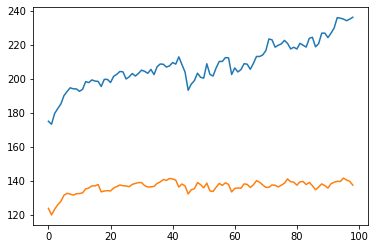

In [4]:
S1_price = df["S1 Close"]
S2_price = df["S2 Close"]
plt.plot(range(0, len(S1_price)), S1_price)
plt.plot(range(0, len(S2_price)), S2_price)

plt.show()

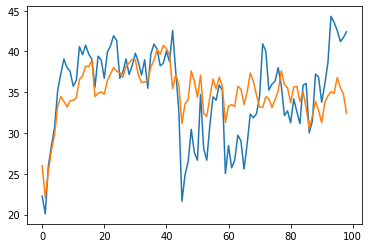

In [5]:
from scipy import signal
s1_detrend = signal.detrend(S1_price) + 35.
s2_detrend = signal.detrend(S2_price) + 35.

plt.plot(range(0, len(S1_price)), s1_detrend)
plt.plot(range(0, len(S2_price)), s2_detrend)

# Set up the environment

## Setting up the Models

In [6]:
from tensorflow.keras.models import Sequential, Model
class ActorCritic(object):
    """ActorCritic model for continous observation space, and discrete action space
    
    Arguments:
        object {[type]} -- [description]
    
    Returns:
        [type] -- [description]
    """
    def __init__(self, env, **kwargs):
        self.env=env

        self.learning_rate = kwargs.get('learning_rate', 0.001)
        self.gamma = kwargs.get('gamma', 0.99)
    
        self.saved_actions = []
        self.saved_values = []
        self.rewards = []
        
        self.actor_model  = self._create_actor_model()
        self.critic_model = self._create_critic_model()

    def _create_actor_model(self):
        model = tf.keras.Sequential([
            kl.Dense(48, activation='relu', input_shape=self.env.observation_space.shape),
            kl.Dense(128, activation='relu'),
            kl.Dense(self.env.action_space.n, activation='softmax', name='policy_logits')
        ])
        model.compile(loss=self._actor_loss(), optimizer='adam')
        return model

    def _create_critic_model(self):
        model = tf.keras.Sequential([
            kl.Dense(48, activation='relu', input_shape=self.env.observation_space.shape),
            kl.Dense(128, activation='relu'),
            kl.Dense(1, activation='relu')
        ])
        model.compile(loss=self._critic_loss(), optimizer='adam')

        return model

    def evaluate_loss(self, y_true, y_pred):
            weighted_sparse_ce = kls.SparseCategoricalCrossentropy(from_logits=False)
            actions = tf.cast(y_true[:,1], tf.int32)
            loss = weighted_sparse_ce(actions, y_pred, sample_weight = y_true[:,0])
            #print(loss)
            return loss
    
    def _actor_loss(self):
        def loss(y_true,y_pred):
            return self.evaluate_loss(y_true, y_pred)
        return loss

    def _critic_loss(self):
        def loss(y_true,y_pred):
            return K.mean(K.square(y_pred - y_true), axis=-1)
        
        return loss

    def train(self, obs_history):
        #pv magic number
        advantages = np.array(self.rewards) - np.array(self.saved_values)
        #take negative since we want to minimize LOSS
        #action_loss = -1*advantages*np.array(self.saved_actions)
        y_label = []
        for adv, action in zip(advantages, np.array(self.saved_actions)):
            y_label.append([adv,action,0])
        
        y_label = np.array(y_label)
        self.actor_model.train_on_batch(np.array(obs_history), y_label)
        self.critic_model.train_on_batch(np.array(obs_history), self.rewards)
    
    def eval_state(self, obs):
        return self.critic_model.predict(obs[None, :])
    
    def predict_action(self, obs):
        logits = self.actor_model.predict(obs[None, :])
        action = tf.squeeze(tf.random.categorical(logits, 1), axis=-1)
        return logits[0]
    
    def predict(self,obs):
        return self.eval_state(obs), self.predict_action(obs)
    
    def reset(self):
        self.saved_actions = []
        self.saved_values = []
        self.rewards = []

In [7]:
env = PairsTradingEnv("AAPL","MSFT")
model = ActorCritic(env)
env.observation_space.shape

(4,)

In [43]:
def trainModel(num_batches, batch_size, num_epochs):
    

    for episode in range(num_epochs):
        obs = env.reset()
        obs_history = []
        model.reset()
        reward = 0
        done = False
        for batch in range(num_batches):
            model.reset()
            counter = 0
            obs_history = []
            while not done and counter < batch_size:
                state_value, actionProb = model.predict(obs)
                action = np.random.choice([0,1,2], p=actionProb)
                
                if(batch == 1 and counter == 3):
                    print(actionProb)
                    if(episode == 0):
                        print(obs)
                if(batch == 2 and counter == 4):
                    print(actionProb)
                
                obs, reward, done, msg = env.step(action)
                obs_history.append(obs[None, :][0])
                model.saved_actions.append(action)
                model.saved_values.append(state_value[0][0])
                model.rewards.append(reward)
                if done:
                    break
                counter+=1
            model.train(obs_history)

        #env.render()

In [45]:
trainModel(100,1,3)

In [ ]:
def testModel(num_runs, length_run, startDay):
    envModel = PairsTradingEnv("AAPL","MSFT")
    envRandom = PairsTradingEnv("AAPL","MSFT")
    
    ModelValue = 10000
    RandomValue = 10000
    
    ModelRewards = []
    RandomRewards = []
    
    for run in range(num_runs):
        obsModel = envModel.reset()
        obsRandom = envRandom.reset()
        #advance     
        for ii in range(startDay):
            obsModel, reward, done, msg = envModel.step(2)
            obsRandom, r, d, msg = envRandom.step(2)
            
        for days in range(length_run):
            state_value, actionProb = model.predict(obsModel)
            action = np.random.choice([0,1,2], p=actionProb)

            obsModel, reward, done, msg = envModel.step(action)
            
            ModelValue *= (1+reward/100)
            
            action = np.random.choice([1,2])
            if obsRandom[3] == 1 and action == 1:
                action = 0
                 
            obsRandom, reward, done, msg = envRandom.step(action)
        
            RandomValue *= (1+reward/100)
            
        ModelRewards.append(ModelValue)
        RandomRewards.append(RandomValue)
        
        if(run == 1):
            envModel.render()
            envRandom.render()
        
    print(np.mean(ModelRewards))
    print(np.mean(RandomRewards))
    
testModel(10, 30, 100)

In [25]:
model.actor_model.save("ActorVersion1")

Instructions for updating:
If using Keras pass *_constraint arguments to layers.
INFO:tensorflow:Assets written to: ActorVersion1\assets


In [26]:
model.critic_model.save("CriticVersion1")

INFO:tensorflow:Assets written to: CriticVersion1\assets
